In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, KFold

%matplotlib inline

In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'
!wget $data

--2023-10-06 12:55:46--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1,4M) [text/plain]
Saving to: ‘data.csv.1’

data.csv.1          100%[===================>]   1,41M  3,38MB/s    in 0,4s    

2023-10-06 12:55:48 (3,38 MB/s) - ‘data.csv.1’ saved [1475504/1475504]



### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [3]:
df = pd.read_csv('data.csv')

# Keep only the columns above
columns = [
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP',
]
df = df[columns]

# Lowercase the column names and replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_').str.lower()

# Fill the missing values with 0
df = df.fillna(0)

# Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average
price_mean = df['msrp'].mean()
df['above_average'] = (df['msrp'] > price_mean).astype(int)
del df['msrp']

# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution.
# Use train_test_split function for that with random_state=1
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp` +
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [4]:
selected_features = [
    'engine_hp',
    'engine_cylinders',
    'highway_mpg',
    'city_mpg',
]

f_aucs = []

for f in selected_features:
    auc_score = roc_auc_score(df['above_average'], df[f])
    
    # If AUC is less than 0.5, invert the variable and recompute the AUC
    if auc_score < 0.5:
        auc_score = roc_auc_score(df['above_average'], -df[f])
        
    f_aucs.append((f, auc_score))
    
f_aucs

[('engine_hp', 0.9157738865600598),
 ('engine_cylinders', 0.765740332665676),
 ('highway_mpg', 0.6307493974364577),
 ('city_mpg', 0.6706787971410986)]

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979 +

In [5]:
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical = ['make', 'model', 'transmission_type', 'vehicle_style']

train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
y_train = df_train['above_average']

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_val = df_val['above_average']

y_pred = model.predict_proba(X_val)[:, 1]

auc_score = roc_auc_score(y_val, y_pred)

round(auc_score, 3)

0.976

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88 +

101
101


/var/folders/gz/rb99vhsj5qv6mj0nbyzrkffh0000gn/T/ipykernel_71229/1691061943.py:18: RuntimeWarning: invalid value encountered in scalar divide
  P = true_positive / (true_positive + false_positive)


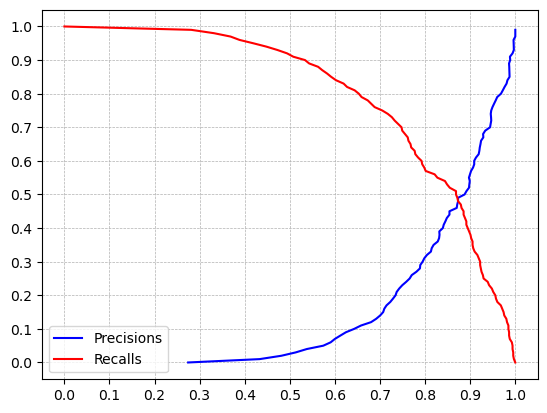

In [6]:
thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []

metrics = []

for t in thresholds:
    predict_above_avarage = (y_pred >= t)
    predict_below_avarage = (y_pred < t)
    actual_above_avarage = (y_val == 1)
    actual_below_avarage = (y_val == 0)
    
    true_positive = (predict_above_avarage & actual_above_avarage).sum()
    false_positive = (predict_above_avarage & actual_below_avarage).sum()
    false_negative = (predict_below_avarage & actual_above_avarage).sum()
    true_negative = (predict_below_avarage & actual_below_avarage).sum()
    
    P = true_positive / (true_positive + false_positive)
    precisions.append(P)
    
    R = true_positive / (true_positive + false_negative)
    recalls.append(R)
    
    metrics.append((t, P, R))

print(len(precisions))
print(len(recalls))

plt.plot(precisions,thresholds, label='Precisions', color='blue')
plt.plot(recalls, thresholds, label='Recalls', color='red')

plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52 +
- 0.72

In [8]:
q4 = [0.12, 0.32, 0.52, 0.72]
q4_res = []
for t, P, R in metrics:
    f1 = 2 * P * R / (P + R)
    if t in q4:
        q4_res.append((t, f1))

max(q4_res, key=lambda x: x[1])

(0.52, 0.87548942834769)

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003 +
- 0.030
- 0.090
- 0.140

In [9]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    
    X = dv.transform(cat)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)
    
    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(cat)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [10]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.980 ± 0.003


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10 +

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [11]:
Cs = [0.01, 0.1, 0.5, 10]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

means = []

for C in Cs:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)
    
    m = np.mean(aucs)
    
    means.append((C, m))

max(means, key=lambda x: x[1])

(10, 0.9822120958925193)

## Submit the results

- Submit your results here: https://forms.gle/E7Fa3WuBw3HkPQYg6
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used